In [8]:
import pandas as pd
import numpy as np
import price_data as price
import ccxt
import chart
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# import the data from the csv file
price_data_csv = pd.read_csv("data/FTX_ETHUSD_1h.csv")

class Context: 
    def __init__(self, price_data, calculation_window, trade_side, context_window=10):
        self.price_data = price_data
        self.calculation_window = calculation_window
        self.context_window = context_window
        self.context_sequence = self.calculate_context_sequence()
        self.trade_side = trade_side
    
    def calculate_context_sequence(self):
        self.context_window
        current_price = price_data.iloc[-1]['open']
        moving_average_channel = chart.ma_channel(price_data, self.calculation_window)
        # ratio between last 10 open prices and the corresponding upper and lower bounds of the moving average channel
        open_prices = price_data.iloc[-self.context_window:]['open']
        upper_bounds = moving_average_channel.iloc[-self.context_window:]['high']
        lower_bounds = moving_average_channel.iloc[-self.context_window:]['low']
        open_upper_ratio = (open_prices-upper_bounds)/(upper_bounds-lower_bounds)
        open_lower_ratio = (open_prices-lower_bounds)/(upper_bounds-lower_bounds)
        upper_lower__open_ratio = (upper_bounds-lower_bounds)/(open_prices)
        normalised_atr = chart.get_normalised_atr(price_data, self.calculation_window).iloc[-self.context_window:]
        # print all lengths 
        context_sequence = np.array([open_upper_ratio, open_lower_ratio, upper_lower__open_ratio, normalised_atr])
        return context_sequence.T

    def get_context_sequence(self):
        trade = 0
        if self.trade_side == 'long':
            trade = 1
        return (trade,self.context_sequence)
        


def identify_trend_variable(price_data, channel_period, no_opens=5, minute=False): #using moving average channel
    channel=chart.ma_channel(price_data,channel_period)
    
    upper_bound=channel.iloc[-no_opens:]['high']
    lower_bound=channel.iloc[-no_opens:]['low']

    if minute:
        opens=price_data.iloc[-no_opens:]['close']
    else:
        opens=price_data.iloc[-no_opens:]['open']
    try:
        if (opens>upper_bound).all():
            return 'uptrend'
        elif (opens<lower_bound).all():
            return 'downtrend'
        else:
            return 'neutral'
    except:
        print(opens, upper_bound, lower_bound)

# price_data = price.get_price_data('1h', symbol='ETH/USD')
price_data = price.get_price_data(data=price_data_csv, timeframe='1h')
print(f"Datapoints: {len(price_data)/24}")
def backtest_strategy(price_data, no_opens, ma_channel_window):

    balance = 1000.0
    position = None
    # ma_channel_window = 24
    # no_opens = 2
    trades =[]
    contextual_data = []
    for i, row in price_data.iterrows():

        if i>ma_channel_window+no_opens:
            
            # Get the open, high, low, and close prices
            current_time = row['unix']
            open_price = row["open"]
            high_price = row["high"]
            low_price = row["low"]
            close_price = row["close"]

            current_price_data = price_data.iloc[0:i]
            if position == 'long':
                profit = (open_price - entry)/entry
            elif position == 'short':
                profit = (entry - open_price)/entry
            channel = chart.ma_channel(current_price_data, ma_channel_window)
            trend = identify_trend_variable(current_price_data,ma_channel_window,no_opens)
            # long_term_trend = identify_trend_variable(current_price_data,ma_channel_window,no_opens+1)

            # entry conditions 
            if position == None:
                # if long_term_trend != trend:
                if trend == 'uptrend': 
                    position = "short"
                    timestamp = row['unix']
                    entry = open_price
                elif trend == 'downtrend':
                    position = "long"
                    timestamp = row['unix']
                    entry = open_price
                trade_context = Context(current_price_data, ma_channel_window, position)

            # exit condition
            # essentially mean reversion
            # if the open_price is above the entry price and below the top of the channel, or the open_price is below the entry price and above the bottom of the channel, exit
            elif (open_price<channel.iloc[-1]['high'] and open_price>entry) or (open_price>channel.iloc[-1]['low'] and open_price<entry) or profit<-0.01:            # calculate the profit/loss and add it to the balance
                # append trade to end of list
                prev_balance = balance
                if position == "long":
                    balance += ((open_price - entry)/entry)*balance
                elif position == "short":
                    balance += ((entry - open_price)/entry)*balance
                trades.append((pd.to_datetime(timestamp, unit='ms'), pd.to_datetime(current_time, unit='ms'),position, open_price, entry, balance, prev_balance<balance, open_price<channel.iloc[-1]['high'] and open_price>entry, open_price>channel.iloc[-1]['low']and open_price<entry))
                contextual_data.append((trade_context, trade_context.get_context_sequence(), prev_balance<balance))
                timestamp=None
                position = None
                
        if balance<=0:
            break

    trades_df = pd.DataFrame(trades, columns=['timestamp', 'timestamp_exit','side', 'exit', 'entry', 'balance', 'win', 'open_below_channel_high', 'open_above_channel_low'])
    print(trades_df)
    win_rate = trades_df['win'].sum()/len(trades_df)
    print(f"Win rate: {win_rate:.2f}")
    # Calculate the overall performance of the strategy
    roi = (balance - 1000.0) / 1000.0
    print(f"ROI: {roi:.2f}")
    return balance, trades_df, contextual_data

# for hourly data it seems around 130 is the best option for the moving channel window
# for minute data it seems around 23 is the best option for the moving channel window

# fib_array = [5,8,13,21,34,55,89,144,233,377,610]
# ma_channel_period = [126,128,130,132]
# no_opens = [2,3,4,5,6]
# results = []
# for ma in ma_channel_period:
#     for no in no_opens:
#         balance, _ = backtest_strategy(price_data, no, ma)
#         print(f"ma_channel_period: {ma}, no_opens: {no}, final balance: {balance:.2f}")
#         results.append((ma, no, balance))

# results_df = pd.DataFrame(results, columns=['ma_channel_period', 'no_opens', 'balance'])
# results_df.sort_values(by='balance', ascending=True, inplace=True)
# print(results_df)

# print the timestamp of the first and last rows of price_data
balance, trades_df, training_data = backtest_strategy(price_data, 4, 128)

Datapoints: 477.75


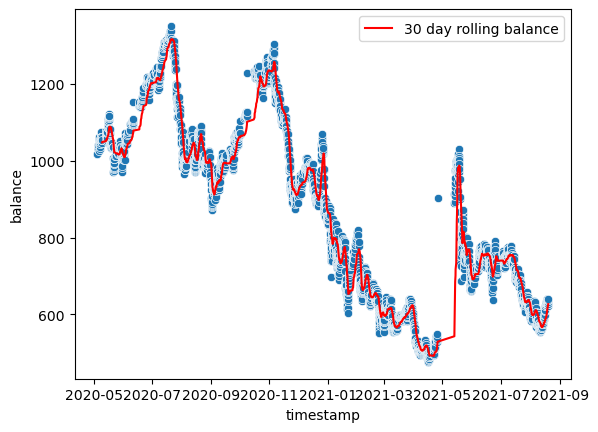

<AxesSubplot: xlabel='timestamp', ylabel='rolling_balance_deriv'>

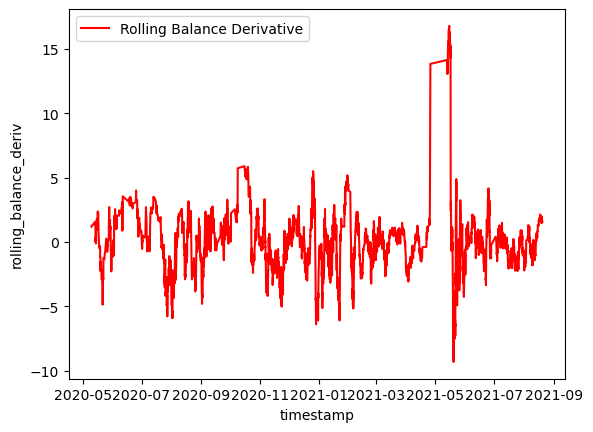

In [ ]:
window = 30
trades_df['rolling_balance'] = trades_df['balance'].rolling(window=window).mean()
trades_df['rolling_balance_deriv'] = trades_df['rolling_balance'].diff()
sns.scatterplot(x='timestamp', y='balance', data=trades_df)
sns.lineplot(x='timestamp', y='rolling_balance', data=trades_df, color='red', label=f'{str(window)} day rolling balance')
plt.show()
# # only show the rows from trades_df where win is false
# losses = trades_df[trades_df['win']==False]
wins = trades_df[trades_df['win']==True]
# # calculate the average loss by taking the differnce between the entry and exit price and dividing by the entry price
# loss = abs(losses['entry']-losses['exit'])/losses['entry']
win = abs(wins['entry']-wins['exit'])/wins['entry']
# print(trades_df)
# print(win.mean()/loss.mean())
sns.lineplot(x='timestamp', y='rolling_balance_deriv', data=trades_df, color='red', label='Rolling Balance Derivative')

In [ ]:
# extract the rows where the derivative is <0
losses = trades_df.loc[trades_df['rolling_balance_deriv']<0]
losses

,timestamp,timestamp_exit,side,exit,entry,balance,win,open_below_channel_high,open_above_channel_low,rolling_balance,rolling_balance_deriv
38,2020-05-14 18:00:00,2020-05-14 19:00:00,short,200.38,197.99,1053.895132,False,False,False,1055.749153,-0.104451
39,2020-05-14 20:00:00,2020-05-14 21:00:00,short,202.70,203.57,1058.399179,True,False,True,1055.648552,-0.100601
65,2020-05-18 00:00:00,2020-05-18 02:00:00,short,214.37,206.96,1042.998379,False,False,False,1088.792621,-0.277021
66,2020-05-18 03:00:00,2020-05-18 07:00:00,short,214.35,214.40,1043.241616,True,False,True,1088.430087,-0.362534
67,2020-05-18 08:00:00,2020-05-18 09:00:00,short,212.17,214.07,1052.501013,True,False,True,1087.954372,-0.475716
...,...,...,...,...,...,...,...,...,...,...,...
2935,2021-08-12 07:00:00,2021-08-12 09:00:00,short,3130.70,3129.60,572.422676,False,True,False,569.759303,-1.008991
2936,2021-08-12 19:00:00,2021-08-12 21:00:00,long,3067.40,3059.50,573.900741,True,True,False,568.731392,-1.027911
2937,2021-08-12 22:00:00,2021-08-12 23:00:00,long,3000.20,3044.40,565.568586,False,False,False,567.665012,-1.066380
2938,2021-08-13 00:00:00,2021-08-13 01:00:00,long,3063.20,3046.90,568.594208,True,True,False,567.102313,-0.562699
